# Подбор гиперпараметров для алгоритма LogisticRegression на примере Breast Cancer Data

Для начала работы загруим необходимые библиотеки и инструменты 

In [249]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate
from scipy.stats import uniform,loguniform
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pylab import rcParams
import mglearn
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, f1_score
from scipy.optimize import fmin
from time import time

# 1. Оптимизация гипрпараметра C

## 1.1. fmin optimization

В качестве рабочего набора данных будет использован встроенный набор данных breast_cancer, содержащий в себе 569 записей и информацию по 9 признакам. Для каждого из этих признаков были рассчитаны среднее значение, стандартная ошибка и «наихудшее» или наибольшее (среднее из трех самых больших значений) значение, что дало 30 признаков. Каждая из записей данных имеет метку Malignant (злокачественная опухоль) (212 записей) или Benign(доброкачественная опухоль) (357).

In [3]:
cancer = load_breast_cancer()

In [4]:
cancer_data = pd.DataFrame.from_dict(cancer['data'])
cancer_target = pd.DataFrame.from_dict(cancer['target'])

# add intercept
cancer_data.insert(0, 'x_0', 1)

print("cancer_data", cancer_data.shape)
print("cancer_target",cancer_target.shape)
print()

# split to train and test sets
X_train = cancer_data[0:457]
y_train = cancer_target [0:457]
X_test = cancer_data[457:]
y_test = cancer_target [457:]

print("Shape X_train", X_train.shape)
print("Shape y_train", y_train.shape)
print()
print("Shape X_test", X_test.shape)
print("Shape y_test", y_test.shape)

cancer_data (569, 31)
cancer_target (569, 1)

Shape X_train (457, 31)
Shape y_train (457, 1)

Shape X_test (112, 31)
Shape y_test (112, 1)


In [5]:
# create arrays
X_train1 = np.array(X_train.values)
y_train1 = np.array(y_train.values)
X_test1 = np.array(X_test.values)
y_test1 = np.array(y_test.values)

# initialise w - vector of parameters
w = np.ones(31)

In [6]:
# define Cost Function for logistic regression with L2 regularization

$$ \large \min_{w} = -[\frac{1}{m}\sum_{i=1}^m y^i log(\frac{1}{1+ e^{-w^Tx}})+(1-y^i)log(\frac{1}{1+ e^{-w^Tx}})] + \frac{\lambda}{2m}\sum_{j=1}^n w^2_j 
$$



 $ m  - \text{number of training examples}$  $n - \text {number of features }$  $x - \text{input variable/features }$ $y - \text{output variable/ target variable}$ $w - \text{parameters of the model }$ $ \lambda - \text{parameter of regularization}$ 

In [7]:
def cost_function_L2_penalty(w,X,y,learningRate):
    
    w = np.matrix(w)
    X = np.matrix(X)
    y = np.matrix(y)
    
    lg = np.log(1/(1 + np.exp(-X*w.T)))
    
    first = np.multiply(-y, lg)
    second = np.multiply((1-y), lg)
    
    penalty = learningRate/(2*len(X))*np.sum(w*w.T)
    
    return np.sum(first - second)/(len(X)) + penalty

In [8]:
learningRate = 1 # LearningRate is alpha = 1 / (n_samples * C)
cost_function_L2_penalty(w,X_train1,y_train1,learningRate)

0.03391684901531729

In [9]:
w_new = fmin(func = cost_function_L2_penalty, x0 = w, args=(X_train1,y_train1,learningRate), maxiter=100)
print(w_new)

[0.99740871 0.98382111 1.03154298 1.0352815  1.03425103 1.00777605
 0.98870541 1.0371062  1.00616981 0.9779672  0.99311712 0.9312597
 0.95998774 1.03402172 0.95327126 0.96552775 0.9855948  0.97447227
 1.01147925 0.98105309 0.99526063 1.01357562 0.99094533 1.01824129
 1.0234979  1.00954558 0.98634959 1.0158313  1.01906068 1.02079928
 0.94900147]


In [12]:
fmin(func = cost_function_L2_penalty, x0 = 0, args=(w_new, X_train1,y_train1,), maxiter=100)

ValueError: shapes (1,31) and (1,1) not aligned: 31 (dim 1) != 1 (dim 0)

## 1.2. Grid Search optimization

### 1.2.1. RandomizedSearchCV (C = [10^-4, 10^0])

In [253]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

import warnings
warnings.filterwarnings("ignore")

RandomizedSearchCV took 15.10 seconds for 100 candidates


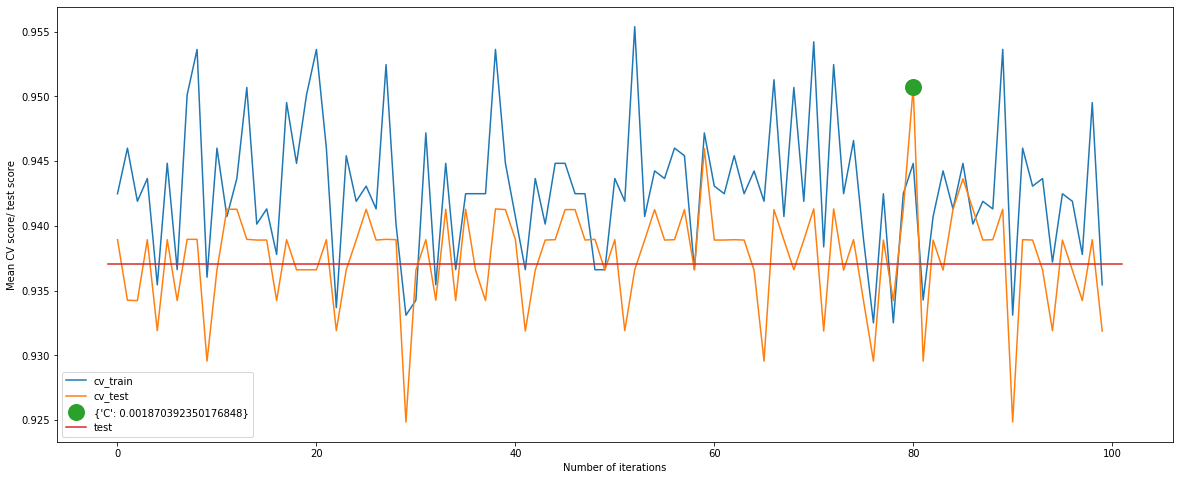

In [254]:
param_grid_log =  {'C': loguniform(10**(-4),10**0)}
random_search_log = RandomizedSearchCV(LogisticRegression(),param_distributions = param_grid_log, 
                                   n_iter = 100, cv = 5,return_train_score=True, random_state = 0)
start = time()
random_search_log.fit(X_train,y_train)

print("RandomizedSearchCV took {:.2f} seconds for {} candidates".format((time() - start),random_search_log.n_iter))

best_C = random_search_log.best_params_
num_iter = random_search_log.n_iter
best_point = random_search_log.best_index_

cv_train_mean_scores = random_search_log.cv_results_['mean_train_score']
cv_test_mean_scores = random_search_log.cv_results_['mean_test_score']
test_score = random_search_log.score(X_test,y_test)

rcParams['figure.figsize'] = 20, 8
plt.plot(np.arange(0,num_iter,1), cv_train_mean_scores, label = 'cv_train')
plt.plot(np.arange(0,num_iter,1), cv_test_mean_scores, label = 'cv_test')
plt.plot(np.arange(0,num_iter,1)[best_point], cv_test_mean_scores[best_point], 'o',markersize=15, mew = 2,
         label = '{}'.format(best_C))
plt.plot([-1,num_iter+1], [test_score,test_score], label = 'test')
plt.xlabel('Number of iterations')
plt.ylabel('Mean CV score/ test score')
plt.legend(loc = 'best')
plt.show()

In [255]:
print("Best parameter {}".format(best_C))
print('Средняя правильность на тренировочном наборе при CrossValidation: {:.2f}'.format(np.mean(cv_train_mean_scores)))
print('Средняя правильность на тестовом наборе при CrossValidation: {:.2f}'.format(np.mean(cv_test_mean_scores)))
print('Правильность на тестовом наборе: {:.2f}'.format(test_score))

Best parameter {'C': 0.001870392350176848}
Средняя правильность на тренировочном наборе при CrossValidation: 0.94
Средняя правильность на тестовом наборе при CrossValidation: 0.94
Правильность на тестовом наборе: 0.94


### 1.2.2. GridSearchCV (C = [10^-4, 10^0])

GridSearchCV took 22.43 seconds for 100 candidates


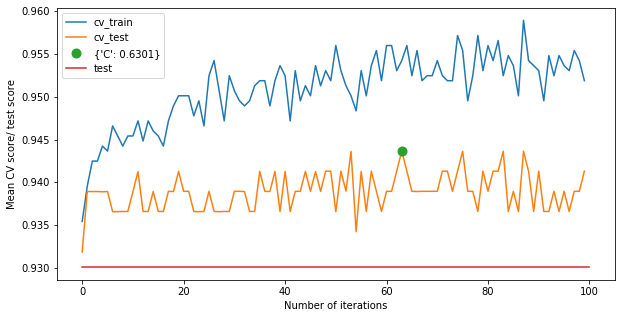

In [257]:
param_grid = {'C': np.arange(10**(-4),10**0,0.01)}

grid_search = GridSearchCV(LogisticRegression(), param_grid, return_train_score=True)
start = time()
grid_search.fit(X_train,y_train)
print("GridSearchCV took {:.2f} seconds for {} candidates".format((time() - start),
                                                                  len(grid_search.cv_results_['params'])))

best_C = grid_search.best_params_
num_iter = len(grid_search.cv_results_['params'])
best_point = grid_search.best_index_

cv_train_mean_scores = grid_search.cv_results_['mean_train_score']
cv_test_mean_scores = grid_search.cv_results_['mean_test_score']
test_score = grid_search.score(X_test,y_test)

rcParams['figure.figsize'] = 10, 5
plt.plot(np.arange(0,num_iter,1), cv_train_mean_scores, label = 'cv_train')
plt.plot(np.arange(0,num_iter,1), cv_test_mean_scores, label = 'cv_test')
plt.plot(np.arange(0,num_iter,1)[best_point], cv_test_mean_scores[best_point], 'o',markersize=8, mew = 2,
         label = '{}'.format(best_C))
plt.plot([0,num_iter], [test_score,test_score], label = 'test')
plt.xlabel('Number of iterations')
plt.ylabel('Mean CV score/ test score')
plt.legend(loc = 'best')
plt.show()

In [258]:
print("Best parameter {}".format(best_C))
print('Средняя правильность на тренировочном наборе при CrossValidation: {:.2f}'.format(np.mean(cv_train_mean_scores)))
print('Средняя правильность на тестовом наборе при CrossValidation: {:.2f}'.format(np.mean(cv_test_mean_scores)))
print('Правильность на тестовом наборе: {:.2f}'.format(test_score))

Best parameter {'C': 0.6301}
Средняя правильность на тренировочном наборе при CrossValidation: 0.95
Средняя правильность на тестовом наборе при CrossValidation: 0.94
Правильность на тестовом наборе: 0.93


### 1.2.3. Best estimators GridSearchCV and RandomizedSearchCV (C = [10^-4, 10^0])

In [259]:
print(grid_search.best_estimator_)
print()
print(random_search_log.best_estimator_)

LogisticRegression(C=0.6301, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.001870392350176848, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


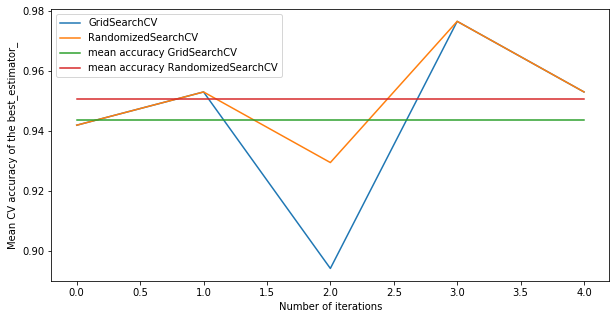

In [260]:
GridS = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
RandS = cross_val_score(random_search_log.best_estimator_, X_train, y_train, cv=5)
rcParams['figure.figsize'] = 10, 5
plt.plot(np.arange(0,len(GridS),1), GridS, label = 'GridSearchCV')
plt.plot(np.arange(0,len(RandS),1), RandS, label = 'RandomizedSearchCV')

plt.plot([0,len(GridS)-1], [np.mean(GridS),np.mean(GridS)], label = 'mean accuracy GridSearchCV')
plt.plot([0,len(RandS)-1], [np.mean(RandS),np.mean(RandS)], label = 'mean accuracy RandomizedSearchCV')


plt.xlabel('Number of iterations')
plt.ylabel('Mean CV accuracy of the best_estimator_')
plt.legend(loc = 'best')
plt.show()

In [261]:
print('Правильность CV для GridSearchCV ={:.2f}, RandomizedSearchCV ={:.2f}'. format(np.mean(GridS),np.mean(RandS)))

Правильность CV для GridSearchCV =0.94, RandomizedSearchCV =0.95


Для начала произведем разбиение обучающего набора для построения модели на 3 части: обучающий набор для построения модели, проверочный (валидационный) набор для выбора параметров модели, тестовый набор для оценки качества работы выбранных параметров.

In [130]:
#Разбивка данных на обчающий, проверочный и тестовый наборы

X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

Задача: обучить классификатор с целью получения наилучших критериев правильности, F-меры, точности и полноты.
Т.к. данные содержат информацию о двух классах (Malignant и Benign), то имеем дело с бинарной классификацией.

В качестве рабочей модели выбрана Логистическая регрессия.

# 2. Feature importance

In [14]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

## 2.1. Feature importance for Decision Tree

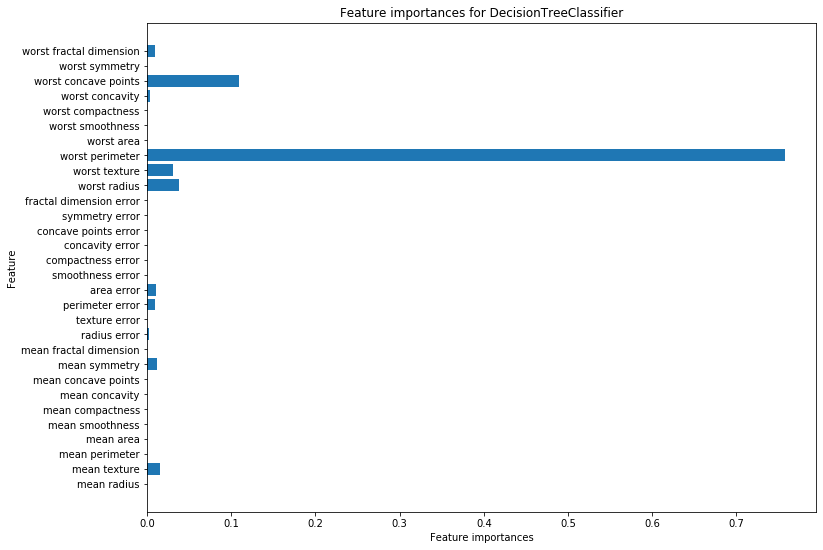

In [244]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

rcParams['figure.figsize'] = 12, 9    
n_reatures = cancer.data.shape[1]
plt.barh(range(n_reatures), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_reatures), cancer.feature_names)
plt.xlabel('Feature importances')
plt.ylabel('Feature')
plt.title("Feature importances for DecisionTreeClassifier")
plt.show()

In [196]:
top_features_dt = ['worst concave points','worst perimeter','worst texture', 'worst radius','mean texture']

## 2.2. Feature importance for Logistic Regression

Top features ['mean radius' 'mean texture' 'mean perimeter' 'texture error'
 'perimeter error' 'worst radius']


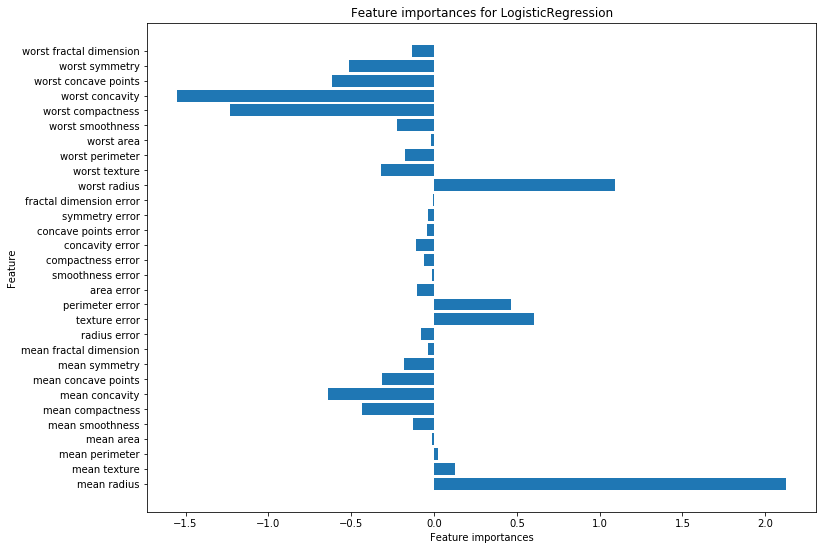

In [227]:
log_reg = LogisticRegression(fit_intercept = False, max_iter= 1000)
log_reg.fit(X_train,y_train)

# The higher the coefficient, the higher the “importance” of a feature.

top_features_coeff = cancer.feature_names[log_reg.coef_.reshape(n_reatures)>0]
print("Top features", top_features_coeff)
n_reatures = cancer.data.shape[1]
plt.barh(range(n_reatures), log_reg.coef_.reshape(n_reatures), align='center')
plt.yticks(np.arange(n_reatures), cancer.feature_names)
plt.xlabel('Feature importances')
plt.ylabel('Feature')
plt.title("Feature importances for LogisticRegression")
plt.show()

In [228]:
from sklearn.feature_selection import RFE

# the 5 most informative features 
selector = RFE(log_reg, 5,step=1)
selector.fit(X_train,y_train)
top_features_rfe = cancer.feature_names[selector.ranking_ == 1]
print("Top 5 features",top_features_rfe)

Top 5 features ['mean concavity' 'mean concave points' 'mean symmetry' 'worst concavity'
 'worst concave points']


In [229]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(log_reg, threshold=-np.inf, max_features=5)
sfm.fit(X_train,y_train)
index = sfm.get_support()
top_features_sfm = cancer.feature_names[index]
print("Top 5 features", top_features_sfm)

Top 5 features ['mean radius' 'mean concavity' 'worst radius' 'worst compactness'
 'worst concavity']


## 2.3. Results for the feature importance 

In [263]:
data = pd.DataFrame(cancer.data, columns=[cancer.feature_names])
X_coeff = np.array(data[top_features_coeff].values)
X_rfe = np.array(data[top_features_rfe].values)
X_sfm = np.array(data[top_features_sfm].values)
X_dt = np.array(data[top_features_dt].values)


X_train_coeff, X_test_coeff, y_train_coeff, y_test_coeff = train_test_split(X_coeff, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

X_train_sfm, X_test_sfm, y_train_sfm, y_test_sfm = train_test_split(X_sfm, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)
print('LogisticRegression')
log_reg.fit(X_train,y_train)
print("Original Logistic Regression: number of features {}, auc = {:.4f}".format(X_train.shape[1], 
                                                   roc_auc_score(y_test, log_reg.decision_function(X_test))))
log_reg.fit(X_train_coeff,y_train_coeff)
print("Coefficient Ranking Method: number of features {}, auc = {:.4f}".format(X_train_coeff.shape[1], 
                                                   roc_auc_score(y_test_coeff, log_reg.decision_function(X_test_coeff))))
log_reg.fit(X_train_rfe,y_train_rfe)
print("RFE: number of features {}, auc = {:.4f}".format(X_train_rfe.shape[1], 
                                                   roc_auc_score(y_test_rfe, log_reg.decision_function(X_test_rfe))))
log_reg.fit(X_train_sfm,y_train_sfm)
print("SFM: number of features {}, auc = {:.4f}".format(X_train_rfe.shape[1], 
                                                   roc_auc_score(y_test_sfm, log_reg.decision_function(X_test_sfm))))
print()
print('DecisionTreeClassifier')
tree.fit(X_train,y_train)
print("Original DecisionTreeClassifier: number of features {}, auc = {:.4f}".format(X_train.shape[1], 
                                                   roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])))
tree.fit(X_train_dt,y_train_dt)
print("DecisionTreeClassifier feature_importances_: number of features {}, auc = {:.4f}".format(X_train_dt.shape[1], 
                                                   roc_auc_score(y_test_dt, tree.predict_proba(X_test_dt)[:,1])))

LogisticRegression
Original Logistic Regression: number of features 30, auc = 0.9925
Coefficient Ranking Method: number of features 6, auc = 0.9396
RFE: number of features 5, auc = 0.9006
SFM: number of features 5, auc = 0.9396

DecisionTreeClassifier
Original DecisionTreeClassifier: number of features 30, auc = 0.9299
DecisionTreeClassifier feature_importances_: number of features 5, auc = 0.9520


# 3. k-folds Cross Validation

Рассмотрим, как на показатель правильности влияет количество блоков, на которые разбиваются тренировочные данные при кросс валидации.

In [266]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

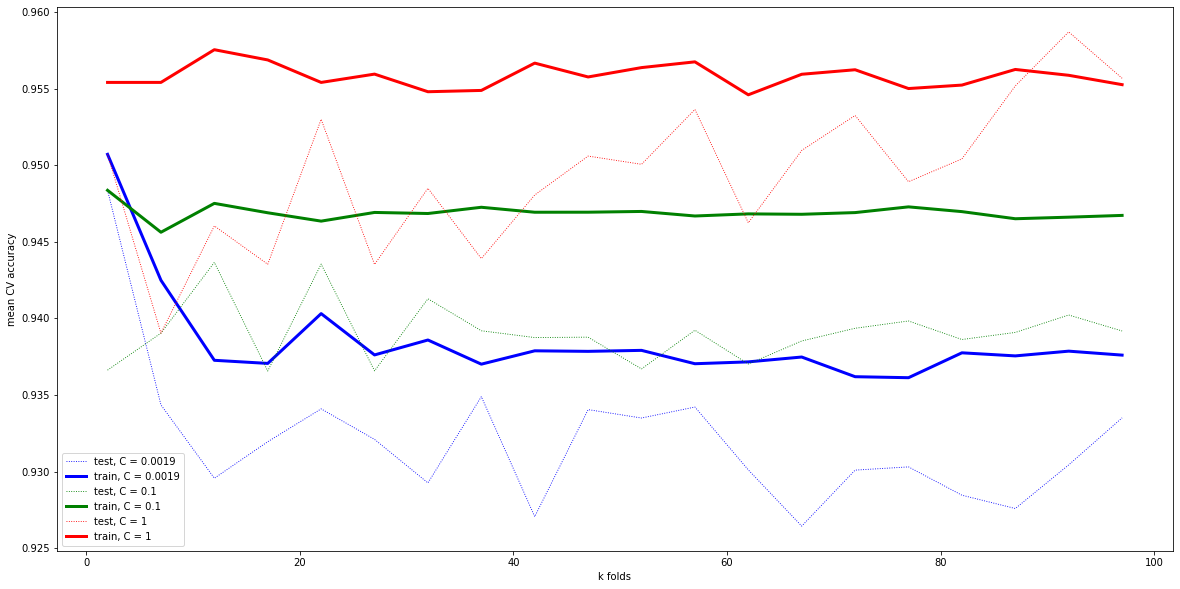

In [359]:
folds = np.arange(2,102,5)
rcParams['figure.figsize'] = 20, 10
for c,col in zip([0.0019, 0.1,1],['b','g','r']):
    mean_test_score_cv = []
    mean_train_score_cv = []

    for k in folds:
        kf = KFold(n_splits=k)
        log_reg = LogisticRegression(C = c)
        log_reg_CV = cross_validate(log_reg, X_train, y_train, cv = kf, return_train_score = True)
        test_score_cv = list(log_reg_CV.items())[2][1]
        train_score_cv = list(log_reg_CV.items())[3][1]
        mean_test_score_cv.append(np.mean(test_score_cv))
        mean_train_score_cv.append(np.mean(train_score_cv))
    
        
    plt.plot(folds, mean_test_score_cv, label = 'test, C = {}'.format(c),linestyle='dotted', c = col,linewidth = 0.9)
    plt.plot(folds, mean_train_score_cv, label = 'train, C = {}'.format(c), c = col, linewidth = 3)
    plt.legend(loc = 'best')
plt.xlabel('k folds')
plt.ylabel('mean CV accuracy')
plt.show()

## 3.1. LeaveOneOut CV

Для осуществления перекрестной проверки с исключением по одному в sklearn есть специальный метод.

In [360]:
X_train.shape # k = 426

(426, 30)

In [387]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
log_reg = LogisticRegression(C = 1)
cv_model = cross_validate(log_reg, X_train,y_train, cv=loo,return_train_score = True)
mean_train = np.mean(list(cv_model.items())[2][1])
mean_test = np.mean(list(cv_model.items())[3][1])

print("Средняя правильность test set: {:.3f}".format(mean_test))
print("Средняя правильность train set: {:.3f}".format(mean_train))     

Средняя правильность test set: 0.956
Средняя правильность train set: 0.951


##  Точность на тестовых данных с подобранным параметром С

In [30]:
log_reg = LogisticRegression(C = 10.04).fit(X_train,y_train)
print("Правильность на обучающем наборе: {:.3f}".format(log_reg.score(X_valid, y_valid)))
print("Правильность на тестовом наборе: {:.3f}".format(log_reg.score(X_test, y_test)))

Правильность на обучающем наборе: 0.981
Правильность на тестовом наборе: 0.937


C = 3e-05 правильность = 0.93 AUC = 0.95
C = 0.001 правильность = 0.92 AUC = 0.97
C = 10.4 правильность = 0.94 AUC = 0.99


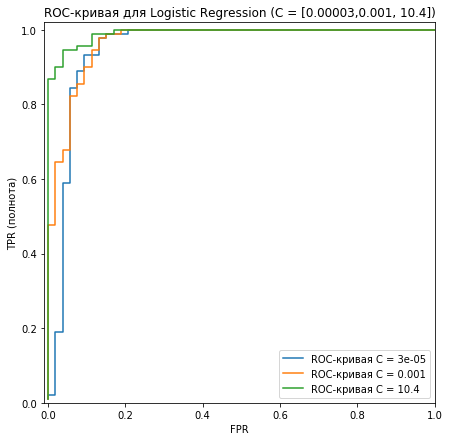

In [31]:
for i in [0.00003, 0.001, 10.4]:
    log_reg = LogisticRegression(C = i).fit(X_trainval,y_trainval)
    accuracy = log_reg.score(X_test, y_test)
    auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, log_reg.decision_function(X_test))
    print("C = {} правильность = {:.2f} AUC = {:.2f}".format(i,accuracy, auc))
    plt.plot(fpr, tpr,  label="ROC-кривая C = {}".format(i))
    
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.title('ROC-кривая для Logistic Regression (C = [0.00003,0.001, 10.4])')
plt.legend()
rcParams['figure.figsize'] = 7, 7
plt.show()

При C = 10.04 ROC кривая приближена к левому верхнему углу, что соответствует тому, что модель имеет маленькое кол-во ложно положительных результатов (определяет класс 0 как класс 1) (низкая вероятность совершить ошибку первого рода) и достаточно высокую полноту, т.е. алгоритм выделяет достаточно много истинных объектов 1 класса. Площадь под кривой (AUC) равна 99, что также говорит о хорошей работе алгоритма.

При высоких параметрах С модель логистической регрессии старается точно определить каждую метку. Высока вероятность переобучения. Однако, в нашем случае модель дала хорошие результаты: 98% точности на тренировочных данных и 94% на тестовых.

## Установка порогового значения по вероятности

Изначально порог принятия реения для решающей функции задан 0: 

* при значении решающей функции < 0, объект относится к классу 0

* при значении решающей функции > 0, объект относится к классу 1


Для вероятности установлен порог принятия решений = 0.5:

* при вероятности < 0.5, объект относится к классу 0 (модель уверена меньше)
* при вероятности > 0.5, объект относится к классу 1 (модель уверена больше)

Эти параметры можно менять для оптимизации модели под требования бизнес задачи.

В исследуемом наборе имеется 2 класса: 
* 'malignant' = 0 (злокачественные опухоли) 
* 'benign' = 1 (доброкачественные опухоли) 

Поставим перед собой следующую задачу: минимизировать долю ложно-положительных результатов, т.е. тех случаев, когда алгоритм предсказывает, что опухоль яв-ся доброкачественной (1), а на самом деле опухоль яв-ся злокачественной (0). В таком случае мы хотим быть уверены, что те пациенты, у кого высокая вероятность доброкачественной опухоли, буду определены алгоритмом точно. Тогда модель должна иметь бОльший порог уверенности, относя пациента к классу 1 и стремиться к 100%  точности в этм классе.

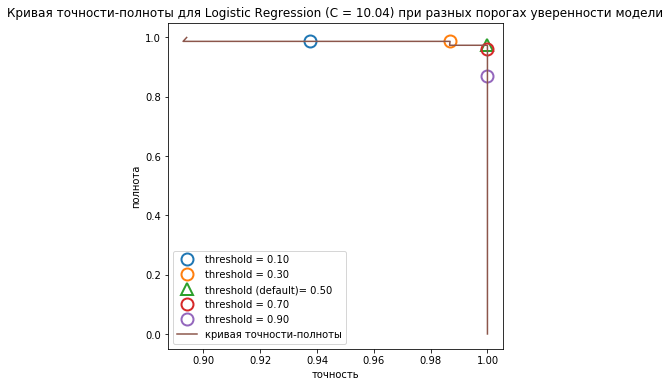

In [389]:
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

# изначально порог на decision_function = 0, redict_proba = 0.5

log_reg = LogisticRegression(C = 10.04) 
log_reg.fit(X_train, y_train) 

precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])

rcParams['figure.figsize'] = 6, 6
for i in np.arange(0.1,1,0.2):
    if round(i,1) == 0.5:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], '^',
                 markersize=12, label="threshold (default)= {:.2f}".format(i), fillstyle="none", mew=2) 
    else:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], 'o',
             markersize=12, label="threshold = {:.2f}".format(i), fillstyle="none", mew=2) 
    
plt.plot(precision, recall, label = 'кривая точности-полноты')
plt.xlabel('точность')
plt.ylabel('полнота')
plt.title('Кривая точности-полноты для Logistic Regression (C = 10.04) при разных порогах уверенности модели')
plt.legend(loc = 'best')
plt.show()

Выведем сводку по показателям точности, полноты и их гармонического среднего (f-меры).

Видим, что алгоритм очень хорошо (100%) определяет пациентов с доброкачественной опухолью и отлично выявляет всех больных пациентов.

In [202]:
print('tresholds = 0.5')
print(classification_report(y_valid,log_reg.predict(X_valid))) 
print()
print('tresholds = 0.7')
y_pred_rise_threshold = log_reg.predict_proba(X_valid) >= 0.7
print(classification_report(y_valid,y_pred_rise_threshold[:,1]))

tresholds = 0.5
             precision    recall  f1-score   support

          0       0.94      1.00      0.97        31
          1       1.00      0.97      0.99        76

avg / total       0.98      0.98      0.98       107


tresholds = 0.7
             precision    recall  f1-score   support

          0       0.91      1.00      0.95        31
          1       1.00      0.96      0.98        76

avg / total       0.97      0.97      0.97       107



При значении порога вероятности равному 0.5 модель дает самые лучшие показатели

# 4. Зависиомсть различных показателей от порога принятия решений

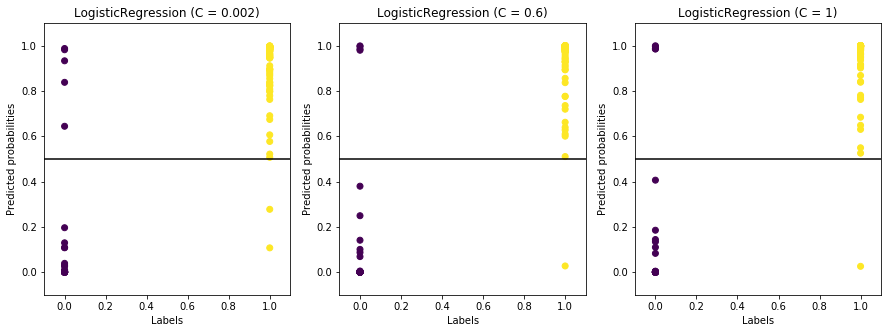

In [590]:
# порог T: все объекты, имеющие предсказание выше порога, относят к классу 1, остальные - к классу 0.
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

for c, ax in zip([0.002, 0.6, 1], axes):
    
    log_reg = LogisticRegression(C = c).fit(X_train,y_train)
    predicted = log_reg.predict_proba(X_valid)[:,1]
    actual = y_valid
    ax.scatter(actual,predicted, c = actual)
    ax.plot([-0.1, 1.1], [0.5, 0.5], c = 'black') # уровень порога
    ax.axis([-0.1, 1.1, -0.1, 1.1])
    ax.set_title("LogisticRegression (C = {})".format(c))
    ax.set_xlabel("Labels")
    ax.set_ylabel("Predicted probabilities")

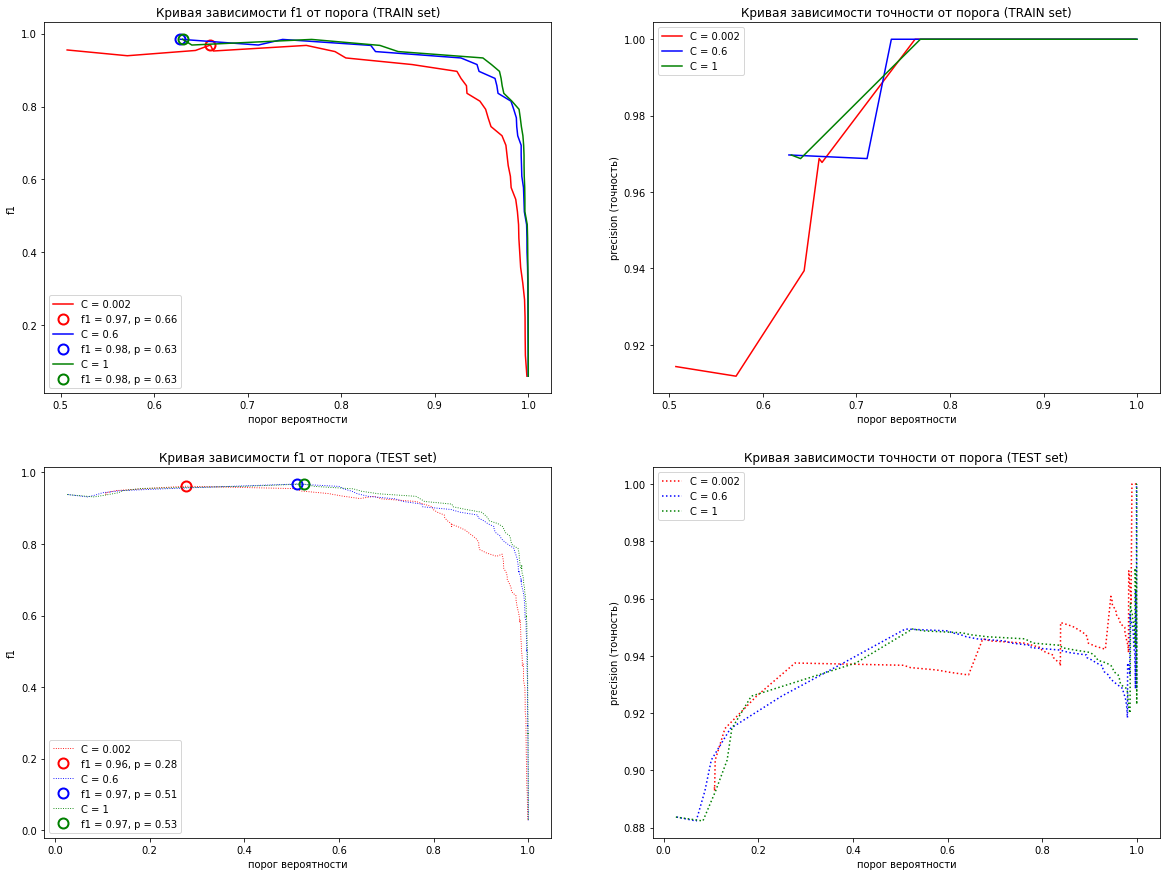

In [589]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15)) 

for c, col in zip([0.002, 0.6, 1], ['r','b','g']):
    log_reg = LogisticRegression(C = c).fit(X_train,y_train)
    
    precision_train, recall_train, tresholds_train = precision_recall_curve(y_train, log_reg.predict_proba(X_train)[:,1])
    precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])
    
    f_scores = []
    f_scores_train = []
    for i in tresholds:
        y_pred_change_threshold = log_reg.predict_proba(X_valid) >= i
        f_scores.append(f1_score(y_valid,y_pred_change_threshold[:,1]))
    for t in tresholds_train:
        y_pred_change_threshold_train = log_reg.predict_proba(X_train) >= t
        f_scores_train.append(f1_score(y_train,y_pred_change_threshold_train[:,1]))   
        
    max_f1 = np.argmax(np.abs(f_scores))
    max_f1_train = np.argmax(np.abs(f_scores_train))
    
    axes[0][0].plot(tresholds_train, f_scores_train, label = 'C = {}'.format(c), c = col)
    axes[0][0].plot(tresholds_train[max_f1_train], f_scores_train[max_f1_train],'o', markersize=10, 
             label="f1 = {:.2f}, p = {:.2f}".format(f_scores_train[max_f1_train],tresholds_train[max_f1_train]), 
             fillstyle="none",mew=2, c = col)
    
    axes[1][0].plot(tresholds, f_scores, label = 'C = {}'.format(c), linestyle='dotted', c = col,linewidth = 0.9)
    axes[1][0].plot(tresholds[max_f1], f_scores[max_f1],'o', markersize=10, 
                    label="f1 = {:.2f}, p = {:.2f}".format(f_scores[max_f1],tresholds[max_f1]), 
                    fillstyle="none",mew=2, c = col)
    
    axes[0][0].set_title('Кривая зависимости f1 от порога (TRAIN set)')
    axes[1][0].set_title('Кривая зависимости f1 от порога (TEST set)')
    axes[0][0].set_xlabel('порог вероятности')
    axes[0][0].set_ylabel('f1')
    axes[0][0].legend(loc = 'best') 
    
    axes[1][0].set_xlabel('порог вероятности')
    axes[1][0].set_ylabel('f1')
    axes[1][0].legend(loc = 'best')
    
    max_precision = np.argmax(np.abs(precision))
    #max_precision_train = np.argmax(np.abs(precision_train))
    
    axes[0][1].plot(tresholds_train, precision_train[:-1], label = 'C = {}'.format(c), c = col)
    #axes[0][1].plot(tresholds_train[max_precision_train], precision_train[:-1][max_precision_train],'o', markersize=10, 
             #label="p = {:.2f}".format(tresholds_train[max_precision_train]), fillstyle="none",mew=2, c = col)
    
    axes[1][1].plot(tresholds, precision[:-1], label = 'C = {}'.format(c), linestyle='dotted', c = col)
    #axes[1][1].plot(tresholds[max_precision], precision[:-1][max_precision],'o', markersize=10, 
             #label="p = {:.2f}".format(tresholds[max_precision]), fillstyle="none",mew=2, c = col)
   
    axes[0][1].set_title('Кривая зависимости точности от порога (TRAIN set)' )
    axes[0][1].set_xlabel('порог вероятности')
    axes[0][1].set_ylabel('precision (точность)')
    axes[0][1].legend(loc = 'best')   
    
    axes[1][1].set_title('Кривая зависимости точности от порога (TEST set)' )
    axes[1][1].set_xlabel('порог вероятности')
    axes[1][1].set_ylabel('precision (точность)')
    axes[1][1].legend(loc = 'best') 
plt.show()

# 5. Размер контрольного множества

In [569]:
#Разбивка данных на обчающий и тестовый наборы с разной величиной контрольной выборки
def procent_of_test_size(control_sizes, data, target):
    scores = []
    data_strucrure = {'%_test_size': ['original'],  # формируем имена колонок
                      'train_size':[cancer.data.shape[0]],
                      'test_size': [cancer.data.shape[0]] , 
                      'mean': [round(np.mean(data))] , 
                      'var': [round(np.var(data))] ,
                      'score': [0]}
    df = pd.DataFrame(data_strucrure)        # создаем датафрейм 
      
    for size in control_sizes:
        train_size = 1 - size
        test_percent = size*100
        X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, 
                                                                  stratify = target, 
                                                                  random_state = 0,
                                                                  test_size = size,
                                                                  train_size = train_size)
        train_size = X_trainval.shape 
        test_size = X_test.shape
        mean = np.mean(X_trainval)
        var = np.var(X_trainval)
    
        
        log_reg = LogisticRegression(C = 10.04)
        kf = KFold(n_splits=12)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
        score = np.mean(scor)
        scores.append(score)
    
    
        new_row = {'%_test_size': test_percent, 
                   'train_size': train_size[0], 
                   'test_size': test_size[0], 
                   'mean': round(mean,2), 
                   'var': round(var,2),
                   'score': round(score,3)}
        
        
        df = df.append(new_row, ignore_index=True)
    
    return df

In [570]:
control_sizes = np.arange(0.01,1,0.1)
cancer_data_df = procent_of_test_size(control_sizes,cancer.data, cancer.target )

In [571]:
print(cancer_data_df)

   %_test_size  train_size  test_size   mean       var  score
0     original       569.0      569.0  62.00  52120.00  0.000
1            1       563.0        6.0  61.92  52150.42  0.947
2           11       506.0       63.0  62.15  53072.78  0.943
3           21       449.0      120.0  61.81  52628.14  0.938
4           31       392.0      177.0  61.60  52321.65  0.962
5           41       335.0      234.0  62.02  53842.41  0.949
6           51       278.0      291.0  62.18  54637.40  0.949
7           61       221.0      348.0  62.29  55988.48  0.937
8           71       165.0      404.0  60.81  51975.95  0.934
9           81       108.0      461.0  60.17  52199.24  0.944
10          91        51.0      518.0  57.15  40691.82  0.942


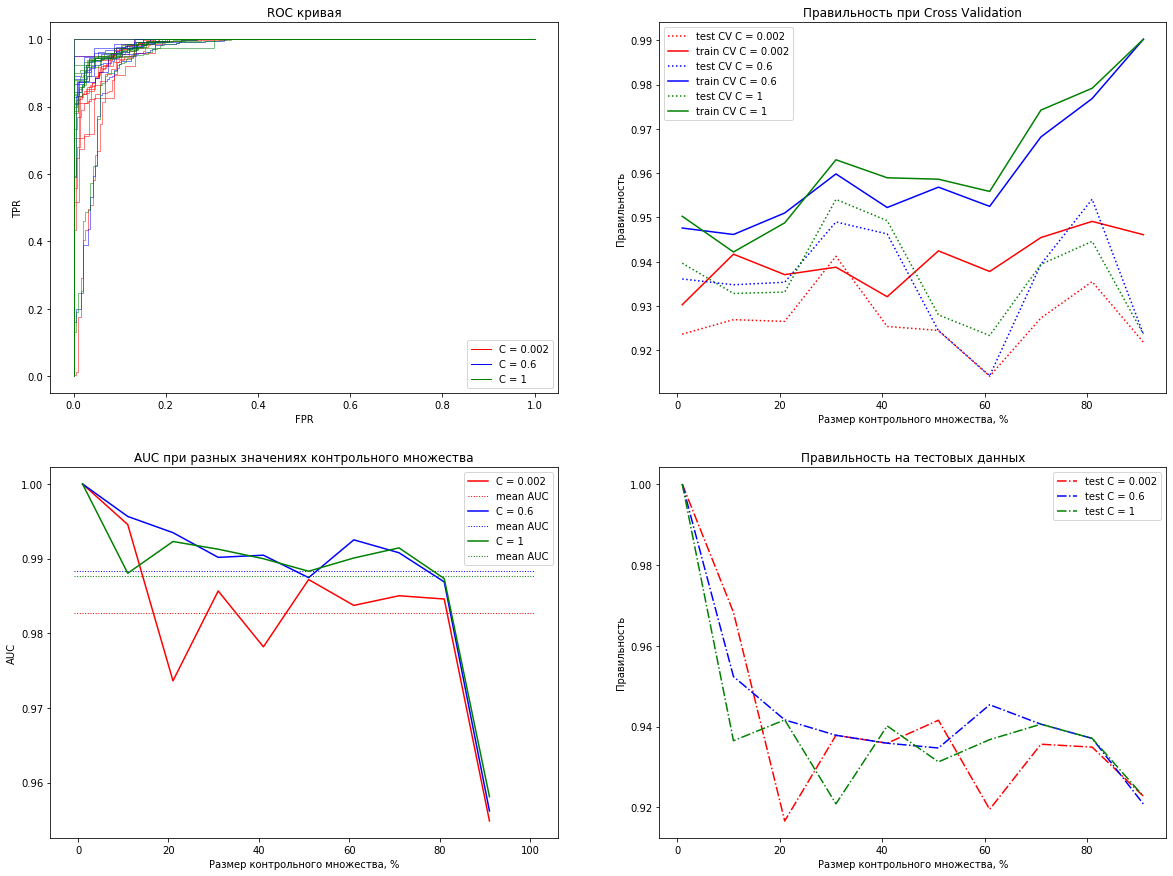

In [594]:
gridsize = (2,2)
fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 1))
ax4 = plt.subplot2grid(gridsize, (1, 0))

control_sizes = np.arange(0.01,1,0.1)

custom_lines = [Line2D([0], [0], color='r', lw=1),
                Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='g', lw=1)]

for c, col in zip([0.002, 0.6, 1],['r','b','g']):
    scores_test = []
    scores_train = []
    real_score = []
    auc_score = []
    for size in control_sizes:
        
        train_size = 1 - size
        test_percent = size*100
        X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                            stratify = cancer.target,
                                                            random_state = 0,
                                                            test_size = size, train_size = train_size)
        log_reg = LogisticRegression(C = c)
        kf = KFold(n_splits = 5)
        score = cross_validate(log_reg, X_train, y_train, cv = kf, return_train_score = True)
        train_score_cv = (list(score.items())[3][1])
        test_score_cv = (list(score.items())[2][1])
        scores_test.append(np.mean(test_score_cv))
        scores_train.append(np.mean(train_score_cv))
        log_reg.fit(X_train,y_train)
        real_score.append(log_reg.score(X_test,y_test))
        
        fpr,tpr, tresholds = roc_curve(y_test, log_reg.decision_function(X_test))
        ax1.plot(fpr,tpr,c = col,linewidth = 0.5)   
        
        auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
        auc_score.append(auc)
    
        
    ax2.plot(control_sizes*100, scores_test, label = 'test CV C = {}'.format(c), c = col,linestyle='dotted')
    ax2.plot(control_sizes*100, scores_train, label = 'train CV C = {}'.format(c), c = col)
    ax3.plot(control_sizes*100, real_score, label = 'test C = {}'.format(c), c = col, linestyle = 'dashdot')
    ax4.plot(control_sizes*100, auc_score, label = 'C = {}'.format(c), c = col)
    ax4.plot((-1,101), (np.mean(auc_score),np.mean(auc_score)), label = 'mean AUC'.format(c), 
             c = col,linestyle='dotted', lw = 1)
    
    ax1.legend(custom_lines, ['C = 0.002', 'C = 0.6', 'C = 1'])
    ax1.set_title("ROC кривая")    
    ax1.set_ylabel("TPR") 
    ax1.set_xlabel("FPR")
    
    ax2.set_ylabel("Правильность")
    ax2.set_xlabel("Размер контрольного множества, %")
    ax2.set_title("Правильность при Cross Validation") 
    ax2.legend(loc='best') 
    
    ax3.set_ylabel("Правильность")
    ax3.set_xlabel("Размер контрольного множества, %")
    ax3.legend(loc='best')
    ax3.set_title("Правильность на тестовых данных") 
    
    ax4.set_ylabel("AUC")
    ax4.set_xlabel("Размер контрольного множества, %")
    ax4.legend(loc ='best')
    ax4.set_title("AUC при разных значениях контрольного множества")
    
plt.show()

# Отбор значимых признаков (PCA) и классификация

### PCA

In [430]:
from sklearn.preprocessing import StandardScaler

In [431]:
# разбиваем выборку на тренировочный и тестовый наборы 
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)

# масштабируем данные, чтобы они имели var = 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [432]:
np.var(X_train_scaled)

1.0000000000000002

In [434]:
# применяем метод PCA (главныйх компонент), чтобы снизить размерность данных (с меньшей потерей информации)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_train_scaled) # оставляем 2 главные компоненты, 
                                                # чтобы данные можно было отрисовать график

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Форма исходного массива: {}".format(str(X_train_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_train_pca.shape)))


Форма исходного массива: (426, 30)
Форма массива после сокращения размерности: (426, 2)


Text(0, 0.5, 'Вторая главная компонента')

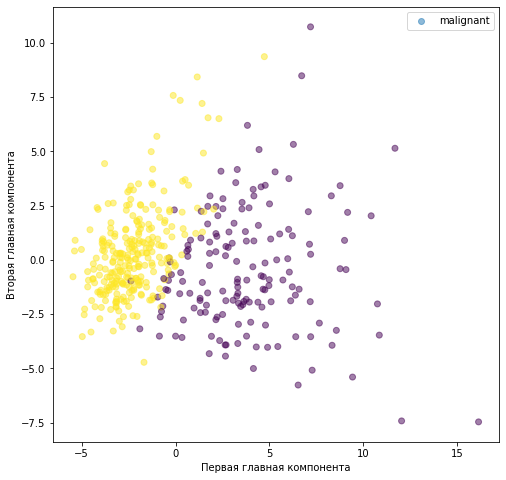

In [435]:
# строим график 
plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c = y_train, alpha= 0.5)

plt.legend(cancer.target_names)

plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")

In [436]:
# Теперь мы можем использовать новое представление, чтобы классифицировать данные
# используя классификатор LinearSVC

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train_pca,y_train)

print("Правильность на обучающем наборе: {:.2f}".format(clf.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(clf.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 0.96
Правильность на тестовом наборе: 0.93


In [437]:
# метод k ближайших соседей

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_pca,y_train)
print("Правильность на обучающем наборе: {:.2f}".format(knn.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(knn.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 1.00
Правильность на тестовом наборе: 0.90


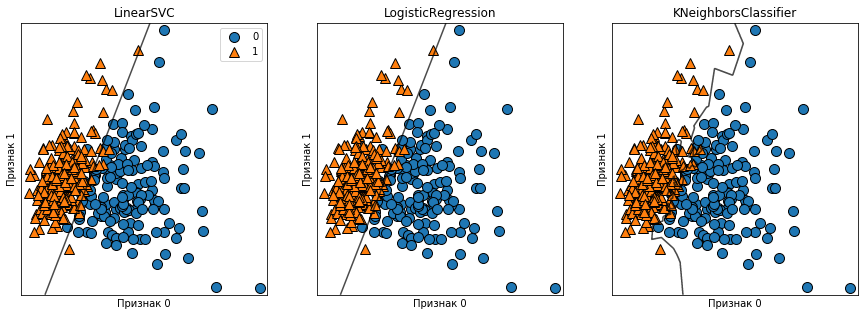

In [438]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for model, ax in zip([LinearSVC(), LogisticRegression(C = 4.6),KNeighborsClassifier(n_neighbors=1)], axes):
    clf = model.fit(X_train_pca, y_train)
    mglearn.plots.plot_2d_separator(clf, X_train_pca, fill=False, eps=0.5, ax=ax, alpha=.7)
    mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel("Признак 0")
    ax.set_ylabel("Признак 1")
axes[0].legend()
plt.show()

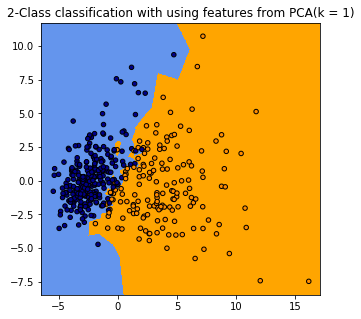

In [444]:
# Отрисуем метод одного ближайшего соседа более подробно

from sklearn import neighbors
n_neighbors = 1

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max()) 
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification with using features from PCA(k = %i)"
% (n_neighbors))

plt.show()

При методе  k ближайших соседей  модель хорошо предсказывает данные на тренировочных данных (100%), но имеет более низкую обобщающую способность (90%). По графикам видно, что модель переобучена.

 На графиках также видно, что метод опорных векторов и логистическая регрессия не сильно отличаются и должны довать схожий результат.
Так оно и есть. 
При методе опорных векторов на тестовой выборке правильность = 96%, на тренировочной = 93%.
При линейной регрессии на тестовой выборке правильность = 97%,  на тренировочной= 94%.
Таким образом, использование логистической регрессии для классификации данного датасета яв-ся более целесообразным.

# GaussianNB

In [446]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)


In [447]:
# стандартиируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [448]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_scaled, y_train)

print("Правильность на обучающем наборе: {:.2f}".format(clf.score(X_train_scaled, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 0.93
Правильность на тестовом наборе: 0.91


In [335]:
def f(x):
    return x**4-8*x**2+5

In [326]:
from scipy import optimize

In [368]:
x = np.array([100])

In [369]:
x 

array([100])

In [370]:
for i in x:
    minimum = optimize.fmin(f, i)
    print(minimum,"\n")

Optimization terminated successfully.
         Current function value: -11.000000
         Iterations: 24
         Function evaluations: 48
[-1.99996948] 



In [360]:
(minimum)


array([-2.])

In [330]:
f(minimum[0])

7.888609052210118e-31

### Решетчатый поиск

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")

In [91]:
from scipy.stats import loguniform

In [92]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)

In [93]:
destribution_randint = randint(10**(-9),10**9).rvs(1000)

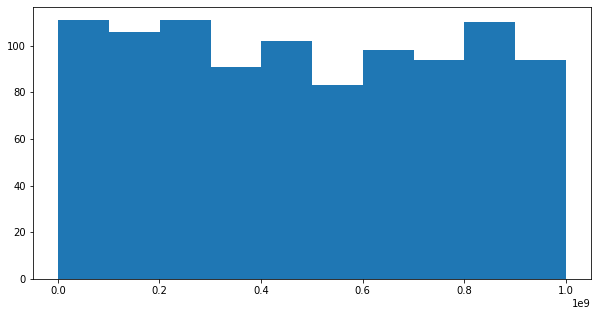

In [94]:
destribution_randint = randint(10**(-9),10**9).rvs(1000)
rcParams['figure.figsize'] = 10, 5
plt.hist(destribution_randint)
plt.show()

In [95]:
param_grid_random = {'C': randint(10**(-9),10**9)}

In [100]:
random_search = RandomizedSearchCV(LogisticRegression(),param_distributions = param_grid_random, 
                                   n_iter = 100, cv = 5,return_train_score=True, random_state = 0)
random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11951b1d0>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=True, scoring=None, verbose=0)

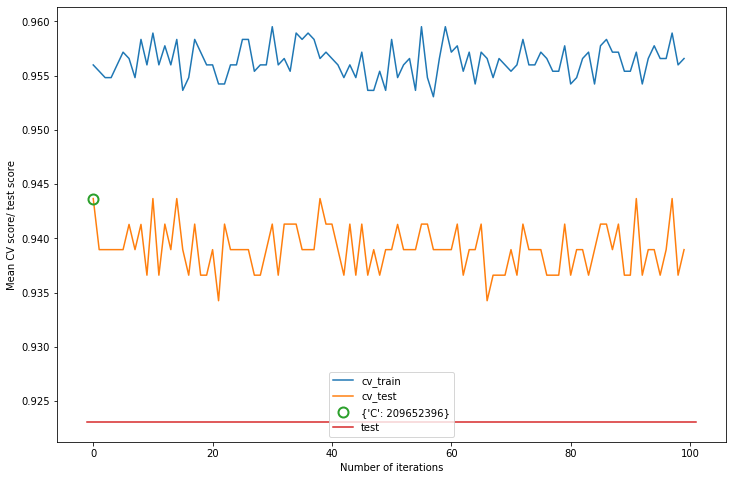

In [101]:
best_C = random_search.best_params_
num_iter = random_search.n_iter
best_point = random_search.best_index_

cv_train_mean_scores = random_search.cv_results_['mean_train_score']
cv_test_mean_scores = random_search.cv_results_['mean_test_score']
test_score = random_search.score(X_test,y_test)

rcParams['figure.figsize'] = 12, 8
plt.plot(np.arange(0,num_iter,1), cv_train_mean_scores, label = 'cv_train')
plt.plot(np.arange(0,num_iter,1), cv_test_mean_scores, label = 'cv_test')
plt.plot(np.arange(0,num_iter,1)[best_point], cv_test_mean_scores[best_point], 'o', 
         fillstyle="none",markersize=10, mew = 2,
         label = '{}'.format(best_C))
plt.plot([-1,num_iter+1], [test_score,test_score], label = 'test')
plt.xlabel('Number of iterations')
plt.ylabel('Mean CV score/ test score')
plt.legend(loc = 'best')
plt.show()

In [102]:
param_grid_random_log = {'C': loguniform(1e-9, 1e9)}

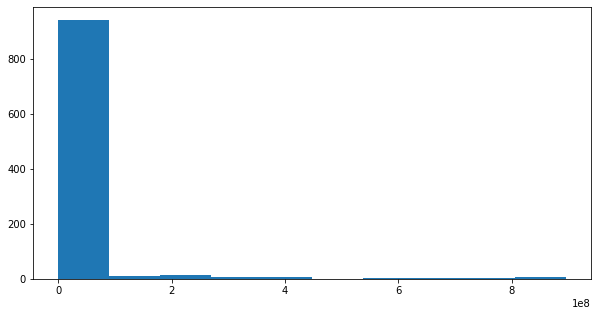

In [103]:
destribution_log = loguniform(10**(-9),10**9).rvs(1000)
rcParams['figure.figsize'] = 10, 5
plt.hist(destribution_log)
plt.show()

In [104]:
param_grid_log =  {'C': loguniform(10**(-9),10**9)}

In [105]:
random_search_log = RandomizedSearchCV(LogisticRegression(),param_distributions = param_grid_log, 
                                   n_iter = 100, cv = 5,return_train_score=True, random_state = 0)
random_search_log.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x119f16390>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=True, scoring=None, verbose=0)

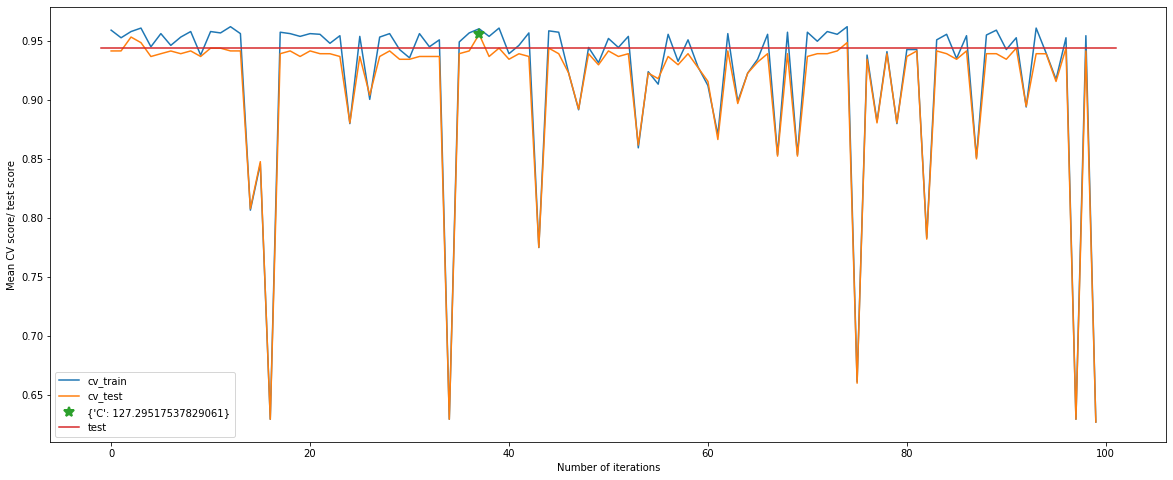

In [116]:
best_C = random_search_log.best_params_
num_iter = random_search_log.n_iter
best_point = random_search_log.best_index_

cv_train_mean_scores = random_search_log.cv_results_['mean_train_score']
cv_test_mean_scores = random_search_log.cv_results_['mean_test_score']
test_score = random_search_log.score(X_test,y_test)

rcParams['figure.figsize'] = 20, 8
plt.plot(np.arange(0,num_iter,1), cv_train_mean_scores, label = 'cv_train')
plt.plot(np.arange(0,num_iter,1), cv_test_mean_scores, label = 'cv_test')
plt.plot(np.arange(0,num_iter,1)[best_point], cv_test_mean_scores[best_point], '*',markersize=10, mew = 2,
         label = '{}'.format(best_C))
plt.plot([-1,num_iter+1], [test_score,test_score], label = 'test')
plt.xlabel('Number of iterations')
plt.ylabel('Mean CV score/ test score')
plt.legend(loc = 'best')
plt.show()

In [111]:
random_search_log.best_estimator_

LogisticRegression(C=127.29517537829061, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
from sklearn.model_selection import GridSearchCV

In [114]:
grid_search = GridSearchCV(LogisticRegression(), np.arange(10**(-9), cv = 5,  
                                 return_train_score=True)

ValueError: Parameter values for parameter (C) need to be a sequence(but not a string) or np.ndarray.

In [115]:
 np.power(10, np.arange(-4, 1, dtype=float))

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [117]:
scipy.stats.loguniform(1e-4, 1e0).rsv(5)

NameError: name 'scipy' is not defined